In [105]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import requests
from io import BytesIO
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# load ratings spreadsheet
ratings_df = pd.read_csv("All_Ratings.csv")

In [43]:
ratings_df.head()

,FileName,Rating
0,AF1.jpg,2
1,AF10.jpg,3
2,AF100.jpg,3
3,AF1000.jpg,4
4,AF1001.jpg,4


In [64]:
# move images into their classified folders
imageFiles = Path('Images').glob("*.jpg")

for f in imageFiles:
    #print(f)
    filename = f.name
    #print(f"filename = {filename}")
    source = f
    rating = ratings_df.loc[ratings_df.FileName == filename, 'Rating'].item()
    #print(f"rating = {rating}")
    destinationFolder = Path("Images") / str(rating)
    destinationFolder.mkdir(parents=True, exist_ok=True)
    destination = Path("Images") / str(rating) / filename
    print(destination)
    source.replace(destination)
    

Images\3\AF10.jpg
Images\3\AF100.jpg
Images\4\AF1000.jpg
Images\4\AF1001.jpg
Images\3\AF1002.jpg
Images\3\AF1003.jpg
Images\3\AF1004.jpg
Images\2\AF1005.jpg
Images\3\AF1006.jpg
Images\3\AF1007.jpg
Images\3\AF1008.jpg
Images\4\AF1009.jpg
Images\2\AF101.jpg
Images\3\AF1010.jpg
Images\3\AF1011.jpg
Images\3\AF1012.jpg
Images\4\AF1013.jpg
Images\4\AF1014.jpg
Images\4\AF1015.jpg
Images\4\AF1016.jpg
Images\4\AF1017.jpg
Images\3\AF1018.jpg
Images\2\AF1019.jpg
Images\3\AF102.jpg
Images\3\AF1020.jpg
Images\3\AF1021.jpg
Images\4\AF1022.jpg
Images\3\AF1023.jpg
Images\3\AF1024.jpg
Images\2\AF1025.jpg
Images\4\AF1026.jpg
Images\4\AF1027.jpg
Images\2\AF1028.jpg
Images\4\AF1029.jpg
Images\3\AF103.jpg
Images\2\AF1030.jpg
Images\4\AF1031.jpg
Images\3\AF1032.jpg
Images\2\AF1033.jpg
Images\3\AF1034.jpg
Images\4\AF1035.jpg
Images\3\AF1036.jpg
Images\2\AF1037.jpg
Images\3\AF1038.jpg
Images\4\AF1039.jpg
Images\3\AF104.jpg
Images\2\AF1040.jpg
Images\2\AF1041.jpg
Images\3\AF1042.jpg
Images\3\AF1043.jpg
Images\

Images\3\AF15.jpg
Images\2\AF150.jpg
Images\4\AF1500.jpg
Images\4\AF1501.jpg
Images\4\AF1502.jpg
Images\3\AF1503.jpg
Images\3\AF1504.jpg
Images\3\AF1505.jpg
Images\4\AF1506.jpg
Images\3\AF1507.jpg
Images\4\AF1508.jpg
Images\2\AF1509.jpg
Images\2\AF151.jpg
Images\4\AF1510.jpg
Images\4\AF1511.jpg
Images\3\AF1512.jpg
Images\4\AF1513.jpg
Images\4\AF1514.jpg
Images\4\AF1515.jpg
Images\3\AF1516.jpg
Images\3\AF1517.jpg
Images\3\AF1518.jpg
Images\4\AF1519.jpg
Images\3\AF152.jpg
Images\3\AF1520.jpg
Images\4\AF1521.jpg
Images\2\AF1522.jpg
Images\4\AF1523.jpg
Images\4\AF1524.jpg
Images\4\AF1525.jpg
Images\4\AF1526.jpg
Images\4\AF1527.jpg
Images\3\AF1528.jpg
Images\4\AF1529.jpg
Images\2\AF153.jpg
Images\4\AF1530.jpg
Images\3\AF1531.jpg
Images\4\AF1532.jpg
Images\4\AF1533.jpg
Images\4\AF1534.jpg
Images\3\AF1535.jpg
Images\4\AF1536.jpg
Images\4\AF1537.jpg
Images\4\AF1538.jpg
Images\2\AF1539.jpg
Images\3\AF154.jpg
Images\1\AF1540.jpg
Images\4\AF1541.jpg
Images\2\AF1542.jpg
Images\4\AF1543.jpg
Images\

Images\1\AF1959.jpg
Images\3\AF196.jpg
Images\2\AF1960.jpg
Images\3\AF1961.jpg
Images\4\AF1962.jpg
Images\3\AF1963.jpg
Images\4\AF1964.jpg
Images\2\AF1965.jpg
Images\4\AF1966.jpg
Images\2\AF1967.jpg
Images\2\AF1968.jpg
Images\3\AF1969.jpg
Images\2\AF197.jpg
Images\3\AF1970.jpg
Images\2\AF1971.jpg
Images\4\AF1972.jpg
Images\5\AF1973.jpg
Images\3\AF1974.jpg
Images\2\AF1975.jpg
Images\1\AF1976.jpg
Images\4\AF1977.jpg
Images\4\AF1978.jpg
Images\3\AF1979.jpg
Images\2\AF198.jpg
Images\4\AF1980.jpg
Images\4\AF1981.jpg
Images\3\AF1982.jpg
Images\4\AF1983.jpg
Images\2\AF1984.jpg
Images\4\AF1985.jpg
Images\1\AF1986.jpg
Images\2\AF1987.jpg
Images\2\AF1988.jpg
Images\4\AF1989.jpg
Images\3\AF199.jpg
Images\4\AF1990.jpg
Images\2\AF1991.jpg
Images\4\AF1992.jpg
Images\4\AF1993.jpg
Images\3\AF1994.jpg
Images\1\AF1995.jpg
Images\2\AF1996.jpg
Images\1\AF1997.jpg
Images\3\AF1998.jpg
Images\3\AF1999.jpg
Images\4\AF2.jpg
Images\3\AF20.jpg
Images\2\AF200.jpg
Images\4\AF2000.jpg
Images\3\AF201.jpg
Images\3\AF

Images\3\AF591.jpg
Images\5\AF592.jpg
Images\4\AF593.jpg
Images\2\AF594.jpg
Images\2\AF595.jpg
Images\3\AF596.jpg
Images\3\AF597.jpg
Images\2\AF598.jpg
Images\3\AF599.jpg
Images\2\AF6.jpg
Images\3\AF60.jpg
Images\3\AF600.jpg
Images\2\AF601.jpg
Images\3\AF602.jpg
Images\4\AF603.jpg
Images\3\AF604.jpg
Images\3\AF605.jpg
Images\3\AF606.jpg
Images\3\AF607.jpg
Images\2\AF608.jpg
Images\2\AF609.jpg
Images\2\AF61.jpg
Images\2\AF610.jpg
Images\3\AF611.jpg
Images\2\AF612.jpg
Images\2\AF613.jpg
Images\3\AF614.jpg
Images\3\AF615.jpg
Images\2\AF616.jpg
Images\2\AF617.jpg
Images\3\AF618.jpg
Images\3\AF619.jpg
Images\3\AF62.jpg
Images\3\AF620.jpg
Images\3\AF621.jpg
Images\2\AF622.jpg
Images\3\AF623.jpg
Images\3\AF624.jpg
Images\3\AF625.jpg
Images\3\AF626.jpg
Images\3\AF627.jpg
Images\3\AF628.jpg
Images\3\AF629.jpg
Images\2\AF63.jpg
Images\4\AF630.jpg
Images\3\AF631.jpg
Images\2\AF632.jpg
Images\4\AF633.jpg
Images\3\AF634.jpg
Images\3\AF635.jpg
Images\4\AF636.jpg
Images\3\AF637.jpg
Images\2\AF638.jpg

Images\3\AF995.jpg
Images\3\AF996.jpg
Images\4\AF997.jpg
Images\3\AF998.jpg
Images\4\AF999.jpg
Images\4\AM1.jpg
Images\1\AM10.jpg
Images\2\AM100.jpg
Images\3\AM1000.jpg
Images\2\AM1001.jpg
Images\2\AM1002.jpg
Images\2\AM1003.jpg
Images\2\AM1004.jpg
Images\2\AM1005.jpg
Images\2\AM1006.jpg
Images\2\AM1007.jpg
Images\2\AM1008.jpg
Images\3\AM1009.jpg
Images\3\AM101.jpg
Images\2\AM1010.jpg
Images\3\AM1011.jpg
Images\2\AM1012.jpg
Images\3\AM1013.jpg
Images\2\AM1014.jpg
Images\2\AM1015.jpg
Images\2\AM1016.jpg
Images\2\AM1017.jpg
Images\3\AM1018.jpg
Images\3\AM1019.jpg
Images\3\AM102.jpg
Images\4\AM1020.jpg
Images\3\AM1021.jpg
Images\2\AM1022.jpg
Images\2\AM1023.jpg
Images\3\AM1024.jpg
Images\3\AM1025.jpg
Images\2\AM1026.jpg
Images\2\AM1027.jpg
Images\2\AM1028.jpg
Images\2\AM1029.jpg
Images\3\AM103.jpg
Images\3\AM1030.jpg
Images\2\AM1031.jpg
Images\2\AM1032.jpg
Images\2\AM1033.jpg
Images\2\AM1034.jpg
Images\2\AM1035.jpg
Images\2\AM1036.jpg
Images\2\AM1037.jpg
Images\3\AM1038.jpg
Images\3\AM103

Images\3\AM1413.jpg
Images\3\AM1414.jpg
Images\2\AM1415.jpg
Images\3\AM1416.jpg
Images\2\AM1417.jpg
Images\3\AM1418.jpg
Images\2\AM1419.jpg
Images\3\AM142.jpg
Images\3\AM1420.jpg
Images\3\AM1421.jpg
Images\3\AM1422.jpg
Images\2\AM1423.jpg
Images\3\AM1424.jpg
Images\2\AM1425.jpg
Images\2\AM1426.jpg
Images\3\AM1427.jpg
Images\3\AM1428.jpg
Images\3\AM1429.jpg
Images\3\AM143.jpg
Images\2\AM1430.jpg
Images\3\AM1431.jpg
Images\3\AM1432.jpg
Images\3\AM1433.jpg
Images\2\AM1434.jpg
Images\3\AM1435.jpg
Images\3\AM1436.jpg
Images\3\AM1437.jpg
Images\3\AM1438.jpg
Images\3\AM1439.jpg
Images\3\AM144.jpg
Images\2\AM1440.jpg
Images\2\AM1441.jpg
Images\2\AM1442.jpg
Images\2\AM1443.jpg
Images\2\AM1444.jpg
Images\3\AM1445.jpg
Images\3\AM1446.jpg
Images\3\AM1447.jpg
Images\3\AM1448.jpg
Images\2\AM1449.jpg
Images\3\AM145.jpg
Images\3\AM1450.jpg
Images\2\AM1451.jpg
Images\2\AM1452.jpg
Images\2\AM1453.jpg
Images\3\AM1454.jpg
Images\2\AM1455.jpg
Images\3\AM1456.jpg
Images\3\AM1457.jpg
Images\2\AM1458.jpg
Imag

Images\2\AM1848.jpg
Images\3\AM1849.jpg
Images\2\AM185.jpg
Images\2\AM1850.jpg
Images\4\AM1851.jpg
Images\4\AM1852.jpg
Images\4\AM1853.jpg
Images\4\AM1854.jpg
Images\3\AM1855.jpg
Images\4\AM1856.jpg
Images\4\AM1857.jpg
Images\4\AM1858.jpg
Images\3\AM1859.jpg
Images\4\AM186.jpg
Images\2\AM1860.jpg
Images\3\AM1861.jpg
Images\4\AM1862.jpg
Images\4\AM1863.jpg
Images\4\AM1864.jpg
Images\3\AM1865.jpg
Images\3\AM1866.jpg
Images\4\AM1867.jpg
Images\4\AM1868.jpg
Images\3\AM1869.jpg
Images\4\AM187.jpg
Images\3\AM1870.jpg
Images\3\AM1871.jpg
Images\3\AM1872.jpg
Images\3\AM1873.jpg
Images\2\AM1874.jpg
Images\3\AM1875.jpg
Images\3\AM1876.jpg
Images\4\AM1877.jpg
Images\4\AM1878.jpg
Images\4\AM1879.jpg
Images\4\AM188.jpg
Images\3\AM1880.jpg
Images\4\AM1881.jpg
Images\3\AM1882.jpg
Images\4\AM1883.jpg
Images\4\AM1884.jpg
Images\4\AM1885.jpg
Images\3\AM1886.jpg
Images\4\AM1887.jpg
Images\3\AM1888.jpg
Images\4\AM1889.jpg
Images\4\AM189.jpg
Images\3\AM1890.jpg
Images\4\AM1891.jpg
Images\4\AM1892.jpg
Image

Images\3\AM498.jpg
Images\2\AM499.jpg
Images\2\AM5.jpg
Images\3\AM50.jpg
Images\3\AM500.jpg
Images\2\AM501.jpg
Images\3\AM502.jpg
Images\3\AM503.jpg
Images\3\AM504.jpg
Images\2\AM505.jpg
Images\3\AM506.jpg
Images\3\AM507.jpg
Images\3\AM508.jpg
Images\3\AM509.jpg
Images\4\AM51.jpg
Images\3\AM510.jpg
Images\3\AM511.jpg
Images\2\AM512.jpg
Images\3\AM513.jpg
Images\2\AM514.jpg
Images\3\AM515.jpg
Images\3\AM516.jpg
Images\3\AM517.jpg
Images\2\AM518.jpg
Images\2\AM519.jpg
Images\2\AM52.jpg
Images\3\AM520.jpg
Images\3\AM521.jpg
Images\2\AM522.jpg
Images\3\AM523.jpg
Images\2\AM524.jpg
Images\3\AM525.jpg
Images\3\AM526.jpg
Images\3\AM527.jpg
Images\3\AM528.jpg
Images\3\AM529.jpg
Images\4\AM53.jpg
Images\3\AM530.jpg
Images\3\AM531.jpg
Images\3\AM532.jpg
Images\3\AM533.jpg
Images\3\AM534.jpg
Images\2\AM535.jpg
Images\2\AM536.jpg
Images\3\AM537.jpg
Images\3\AM538.jpg
Images\2\AM539.jpg
Images\3\AM54.jpg
Images\3\AM540.jpg
Images\3\AM541.jpg
Images\2\AM542.jpg
Images\3\AM543.jpg
Images\3\AM544.jpg


Images\3\AM92.jpg
Images\2\AM920.jpg
Images\2\AM921.jpg
Images\3\AM922.jpg
Images\2\AM923.jpg
Images\3\AM924.jpg
Images\3\AM925.jpg
Images\2\AM926.jpg
Images\3\AM927.jpg
Images\3\AM928.jpg
Images\2\AM929.jpg
Images\2\AM93.jpg
Images\2\AM930.jpg
Images\3\AM931.jpg
Images\2\AM932.jpg
Images\3\AM933.jpg
Images\2\AM934.jpg
Images\2\AM935.jpg
Images\2\AM936.jpg
Images\3\AM937.jpg
Images\3\AM938.jpg
Images\3\AM939.jpg
Images\3\AM94.jpg
Images\3\AM940.jpg
Images\2\AM941.jpg
Images\3\AM942.jpg
Images\3\AM943.jpg
Images\2\AM944.jpg
Images\2\AM945.jpg
Images\3\AM946.jpg
Images\2\AM947.jpg
Images\3\AM948.jpg
Images\3\AM949.jpg
Images\2\AM95.jpg
Images\3\AM950.jpg
Images\2\AM951.jpg
Images\2\AM952.jpg
Images\3\AM953.jpg
Images\3\AM954.jpg
Images\3\AM955.jpg
Images\2\AM956.jpg
Images\2\AM957.jpg
Images\2\AM958.jpg
Images\2\AM959.jpg
Images\2\AM96.jpg
Images\3\AM960.jpg
Images\3\AM961.jpg
Images\3\AM962.jpg
Images\3\AM963.jpg
Images\2\AM964.jpg
Images\3\AM965.jpg
Images\3\AM966.jpg
Images\3\AM967.jp

Images\3\CF485.jpg
Images\3\CF486.jpg
Images\2\CF487.jpg
Images\3\CF488.jpg
Images\3\CF489.jpg
Images\4\CF49.jpg
Images\3\CF490.jpg
Images\2\CF491.jpg
Images\2\CF492.jpg
Images\3\CF493.jpg
Images\2\CF494.jpg
Images\3\CF495.jpg
Images\2\CF496.jpg
Images\3\CF497.jpg
Images\3\CF498.jpg
Images\2\CF499.jpg
Images\4\CF5.jpg
Images\4\CF50.jpg
Images\3\CF500.jpg
Images\2\CF501.jpg
Images\3\CF502.jpg
Images\3\CF503.jpg
Images\2\CF504.jpg
Images\3\CF505.jpg
Images\3\CF506.jpg
Images\3\CF507.jpg
Images\3\CF508.jpg
Images\3\CF509.jpg
Images\2\CF51.jpg
Images\4\CF510.jpg
Images\2\CF511.jpg
Images\3\CF512.jpg
Images\2\CF513.jpg
Images\2\CF514.jpg
Images\2\CF515.jpg
Images\3\CF516.jpg
Images\2\CF517.jpg
Images\2\CF518.jpg
Images\3\CF519.jpg
Images\3\CF52.jpg
Images\3\CF520.jpg
Images\2\CF521.jpg
Images\3\CF522.jpg
Images\2\CF523.jpg
Images\3\CF524.jpg
Images\2\CF525.jpg
Images\3\CF526.jpg
Images\3\CF527.jpg
Images\3\CF528.jpg
Images\3\CF529.jpg
Images\2\CF53.jpg
Images\3\CF530.jpg
Images\3\CF531.jpg


Images\3\CM239.jpg
Images\3\CM24.jpg
Images\2\CM240.jpg
Images\3\CM241.jpg
Images\3\CM242.jpg
Images\2\CM243.jpg
Images\3\CM244.jpg
Images\3\CM245.jpg
Images\3\CM246.jpg
Images\3\CM247.jpg
Images\2\CM248.jpg
Images\3\CM249.jpg
Images\3\CM25.jpg
Images\3\CM250.jpg
Images\4\CM251.jpg
Images\3\CM252.jpg
Images\2\CM253.jpg
Images\3\CM254.jpg
Images\3\CM255.jpg
Images\3\CM256.jpg
Images\2\CM257.jpg
Images\3\CM258.jpg
Images\3\CM259.jpg
Images\2\CM26.jpg
Images\3\CM260.jpg
Images\3\CM261.jpg
Images\3\CM262.jpg
Images\3\CM263.jpg
Images\3\CM264.jpg
Images\3\CM265.jpg
Images\3\CM266.jpg
Images\3\CM267.jpg
Images\3\CM268.jpg
Images\3\CM269.jpg
Images\3\CM27.jpg
Images\3\CM270.jpg
Images\3\CM271.jpg
Images\3\CM272.jpg
Images\3\CM273.jpg
Images\2\CM274.jpg
Images\3\CM275.jpg
Images\3\CM276.jpg
Images\3\CM277.jpg
Images\4\CM278.jpg
Images\2\CM279.jpg
Images\3\CM28.jpg
Images\3\CM280.jpg
Images\3\CM281.jpg
Images\3\CM282.jpg
Images\3\CM283.jpg
Images\3\CM284.jpg
Images\3\CM285.jpg
Images\3\CM286.jp

Images\3\CM695.jpg
Images\4\CM696.jpg
Images\4\CM697.jpg
Images\3\CM698.jpg
Images\4\CM699.jpg
Images\4\CM7.jpg
Images\3\CM70.jpg
Images\5\CM700.jpg
Images\4\CM701.jpg
Images\3\CM702.jpg
Images\4\CM703.jpg
Images\3\CM704.jpg
Images\4\CM705.jpg
Images\4\CM706.jpg
Images\4\CM707.jpg
Images\4\CM708.jpg
Images\4\CM709.jpg
Images\2\CM71.jpg
Images\4\CM710.jpg
Images\4\CM711.jpg
Images\4\CM712.jpg
Images\4\CM713.jpg
Images\4\CM714.jpg
Images\4\CM715.jpg
Images\4\CM716.jpg
Images\4\CM717.jpg
Images\4\CM718.jpg
Images\4\CM719.jpg
Images\4\CM72.jpg
Images\4\CM720.jpg
Images\4\CM721.jpg
Images\4\CM722.jpg
Images\3\CM723.jpg
Images\4\CM724.jpg
Images\4\CM725.jpg
Images\3\CM726.jpg
Images\4\CM727.jpg
Images\4\CM728.jpg
Images\4\CM729.jpg
Images\4\CM73.jpg
Images\4\CM730.jpg
Images\4\CM731.jpg
Images\4\CM732.jpg
Images\3\CM733.jpg
Images\4\CM734.jpg
Images\4\CM735.jpg
Images\4\CM736.jpg
Images\4\CM737.jpg
Images\4\CM738.jpg
Images\4\CM739.jpg
Images\3\CM74.jpg
Images\4\CM740.jpg
Images\3\CM741.jpg


In [65]:
for index, row in ratings_df.iterrows():
    print(row['FileName'])
    print(row['Rating'])
    break
    

AF1.jpg
2


In [66]:
# get rating for file AF1000.jpg
rating = ratings_df.loc[ratings_df.FileName == 'AF1000.jpg', 'Rating'].item()
rating

4

In [67]:
ratings_df.describe()

,Rating
count,5500.000000
mean,3.017636
std,0.735568
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,5.000000


In [68]:
# print tensorflow version
print(tf.__version__)

2.3.0


In [69]:
# set data_dir to the Images folder
data_dir = Path("Images")

In [71]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5500


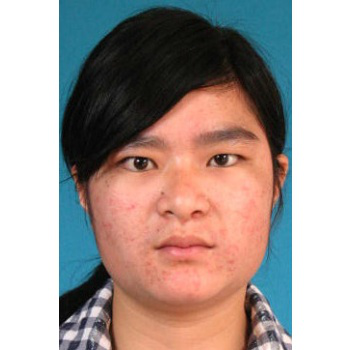

In [75]:
# rating of 1
image1s = list(data_dir.glob('1/*'))
PIL.Image.open(str(image1s[0]))

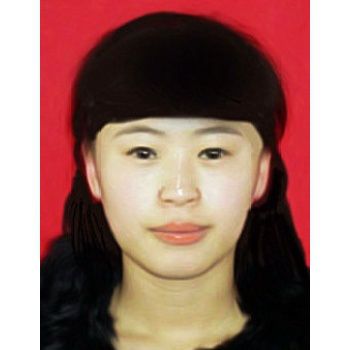

In [76]:
# rating of 2
image2s = list(data_dir.glob('2/*'))
PIL.Image.open(str(image2s[0]))

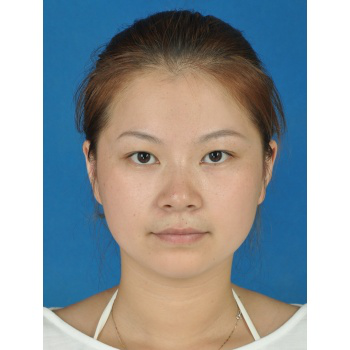

In [98]:
# rating of 3
image3s = list(data_dir.glob('3/*'))
PIL.Image.open(str(image3s[1]))

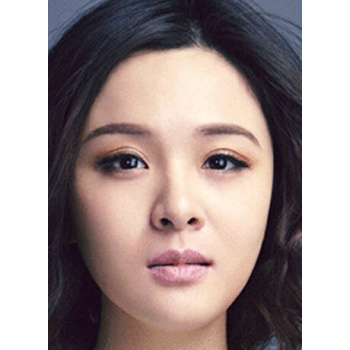

In [78]:
# rating of 4
image4s = list(data_dir.glob('4/*'))
PIL.Image.open(str(image4s[0]))

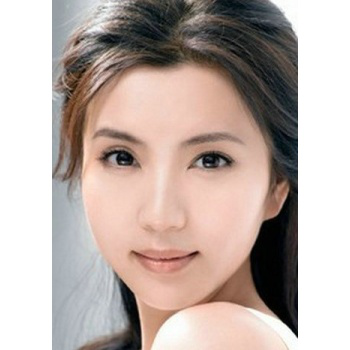

In [79]:
# rating of 5
image5s = list(data_dir.glob('5/*'))
PIL.Image.open(str(image5s[0]))

In [80]:
# Define some parameters for the loader
batch_size = 16
img_height = 350
img_width = 350

In [81]:
# split data 80% training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5500 files belonging to 5 classes.
Using 4400 files for training.


In [82]:
# and 20% validation (test)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5500 files belonging to 5 classes.
Using 1100 files for validation.


In [84]:
# these are the beauty scores
class_names = train_ds.class_names
print(class_names)

['1', '2', '3', '4', '5']


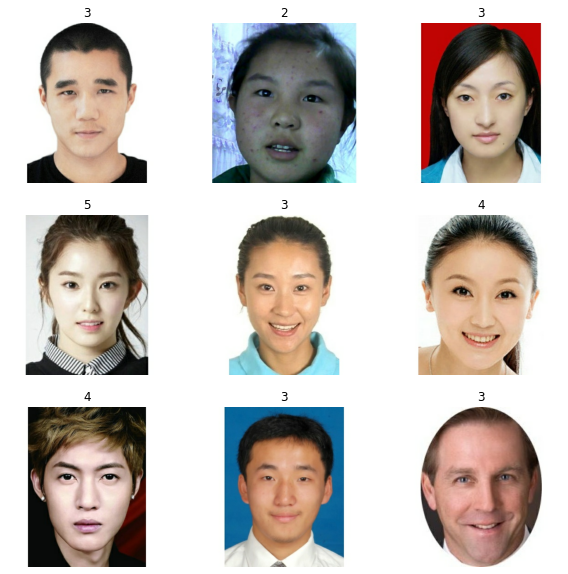

In [85]:
# visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [86]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 350, 350, 3)
(16,)


In [92]:
# scaling
from tensorflow.keras import layers
# include scaling inside model definition

In [93]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [94]:
# Create the model
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [95]:
# Compile the model
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [96]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 350, 350, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 175, 175, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 175, 175, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)       

In [97]:
# Train the model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
275/275 [==============================] - 181s 657ms/step - loss: 1.0570 - accuracy: 0.5575 - val_loss: 0.9114 - val_accuracy: 0.6000
Epoch 2/10
275/275 [==============================] - 183s 666ms/step - loss: 0.8548 - accuracy: 0.6148 - val_loss: 0.8647 - val_accuracy: 0.6345
Epoch 3/10
275/275 [==============================] - 181s 658ms/step - loss: 0.7691 - accuracy: 0.6457 - val_loss: 0.9655 - val_accuracy: 0.5936
Epoch 4/10
275/275 [==============================] - 179s 650ms/step - loss: 0.6492 - accuracy: 0.7082 - val_loss: 0.9929 - val_accuracy: 0.5845
Epoch 5/10
275/275 [==============================] - 179s 651ms/step - loss: 0.5389 - accuracy: 0.7570 - val_loss: 1.1643 - val_accuracy: 0.5691
Epoch 6/10
275/275 [==============================] - 181s 658ms/step - loss: 0.3988 - accuracy: 0.8295 - val_loss: 1.8245 - val_accuracy: 0.4945
Epoch 7/10
275/275 [==============================] - 186s 678ms/step - loss: 0.2938 - accuracy: 0.8768 - val_loss: 1.7395 -

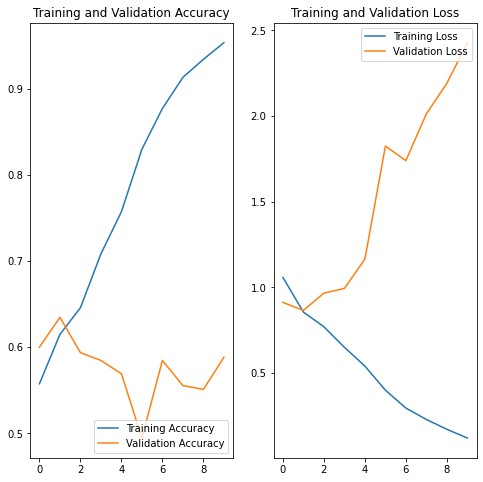

In [99]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

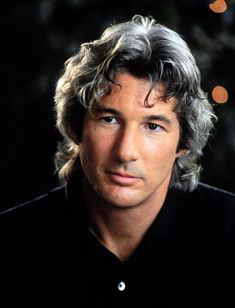

In [108]:
# Predict on new data
rgear_url = "https://i.pinimg.com/236x/a2/4f/35/a24f351c4149f0fc2da71efa77599297.jpg"
response = requests.get(rgear_url)
PIL.Image.open(BytesIO(response.content))

In [109]:
rgear_path = tf.keras.utils.get_file('a24f351c4149f0fc2da71efa77599297', origin=rgear_url)

img = keras.preprocessing.image.load_img(
    rgear_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image has a beauty score of {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image has a beauty score of 4 with a 100.00 percent confidence.


In [102]:
# save the model
import joblib
model.save("beautyScore.h5")

In [103]:
# load the model
from tensorflow.keras.models import load_model
beautyScore_model = load_model("beautyScore.h5")

In [104]:
# Evaluating the loaded model
predictions = beautyScore_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image has a beauty score of {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image has a beauty score of 4 with a 100.00 percent confidence.
